# Data 100 Final Project
### Spring 2020

---

Name: Jemmy Zhou <br>
ID: 3032702532 <br>
Dataset: Basketball

---

## Background

The average salary for an NBA player in the 2018-2019 season was \\$6,388,007. Stephen Curry, star point guard of the Golden State Warriors, was the highest paid player during that season and received $37.46 million. In this paper, I analyze data from two data sets and develop a machine learning classification model that is capable of predicting the annual salary of an NBA player in any given season. I use the provided `Player Box Score` data set and ESPN's `Salary` data set.In the NBA, there is often a direct correlation between a player's stats and their yearly earnings. (This is true for any job). Let's try to predict NBA player salaries given their seasonal statistics!

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd

import os
import glob
import requests
import csv
import lxml.html as lh

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Web Scraping

To get the salary of every player from 2013-2018, I wrote a script to do some webscraping from ESPN. I retrieved the HTML of the webpage and parsed out the table. From there, I stored the table into a .csv file and then brought it back via Pandas. I chose to store the data into a .csv file so I won't have to rerun this script in the future.


_The script is currently commented out, so I don't have to run it everytime I run the notebook._

## Getting the Data

In [2]:
salaries = pd.read_csv('./data/salaries.csv')
players = pd.read_csv('./data/Basketball-PlayerBoxScore.csv')

In [3]:
salaries.head(5)

,RK,NAME,TEAM,SALARY,2013
0,1,"Kobe Bryant, SF",Los Angeles Lakers,"$30,453,805",2013
1,2,"Dirk Nowitzki, F",Dallas Mavericks,"$20,907,128",2013
2,3,"Amar'e Stoudemire, C",New York Knicks,"$19,948,799",2013
3,4,"Joe Johnson, G",Brooklyn Nets,"$19,752,645",2013
4,5,"Carmelo Anthony, PF",New York Knicks,"$19,444,503",2013


In [4]:
players.head(5)

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Southeast,Away,Loss,...,1.0,1,1,2,CLE,East,Central,Home,Win,0
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Southeast,Away,Loss,...,0.5,1,2,3,CLE,East,Central,Home,Win,0
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Southeast,Away,Loss,...,0.5,5,2,7,CLE,East,Central,Home,Win,0
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Southeast,Away,Loss,...,1.0,0,3,3,CLE,East,Central,Home,Win,0
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Southeast,Away,Loss,...,0.0,1,0,1,CLE,East,Central,Home,Win,0


## Cleaning the Data

### Cleaning `salaries`

ESPN includes the column names every ten rows in the original data set. While these rows improve clarity of the data for ESPN's purposes, we need to remove them for our model. I started cleaning the data by filtering out any rows with \c{"RK"} in the \c{RK} (Rank) column. The rank column orders the players from highest annual salary to lowest. This serves no purpose for our data set, so I dropped the column after this step.

In [5]:
salaries = salaries[salaries['RK'] != 'RK']
salaries = salaries.drop(columns=['RK'])

Now we separate players' names into first and last names to match the way the `players` table identifies players. We can drop the `NAME` column after.

In [6]:
salaries['firstName'] = salaries['NAME'].str.extract('(.*?)\s')
salaries['lastName'] = salaries['NAME'].str.extract('\s(.*?),')
salaries = salaries.drop(columns=['NAME'])

In [7]:
salaries.head(5)

,TEAM,SALARY,2013,firstName,lastName
0,Los Angeles Lakers,"$30,453,805",2013,Kobe,Bryant
1,Dallas Mavericks,"$20,907,128",2013,Dirk,Nowitzki
2,New York Knicks,"$19,948,799",2013,Amar'e,Stoudemire
3,Brooklyn Nets,"$19,752,645",2013,Joe,Johnson
4,New York Knicks,"$19,444,503",2013,Carmelo,Anthony


Salary is currently a string, which is impossible for us to classify on. Thus, we must convert salary to integers. (NBA salaries don't have decimals...). We'll also lowercase the column names to keep with the scheme.

In [8]:
salaries['SALARY'] = salaries['SALARY'].str.replace('[\$,]', '').astype(int)
salaries = salaries.rename(columns={'TEAM': 'team', 'SALARY': 'salary'})

In [9]:
salaries.head(5)

,team,salary,2013,firstName,lastName
0,Los Angeles Lakers,30453805,2013,Kobe,Bryant
1,Dallas Mavericks,20907128,2013,Dirk,Nowitzki
2,New York Knicks,19948799,2013,Amar'e,Stoudemire
3,Brooklyn Nets,19752645,2013,Joe,Johnson
4,New York Knicks,19444503,2013,Carmelo,Anthony


In [10]:
salaries.dtypes

team         object
salary        int64
2013          int64
firstName    object
lastName     object
dtype: object

We'll rename `2013`, the year column to `season`.

In [11]:
salaries = salaries.rename(columns={'2013': 'season'})

In [12]:
salaries.head(5)

,team,salary,season,firstName,lastName
0,Los Angeles Lakers,30453805,2013,Kobe,Bryant
1,Dallas Mavericks,20907128,2013,Dirk,Nowitzki
2,New York Knicks,19948799,2013,Amar'e,Stoudemire
3,Brooklyn Nets,19752645,2013,Joe,Johnson
4,New York Knicks,19444503,2013,Carmelo,Anthony


While a player's first name and last name is generally enough to match players when joining the two tables, there's also a possibility of players with the same name. In that case we'll want to make sure that when we join the tables, we check the teams are the same. We'll assume that there are no two players on the same team with the same name. (This should be safe after some brief research on [reddit](https://www.reddit.com/r/nba/comments/52pz9w/have_any_two_players_with_the_exact_same_name/)...) 

The final thing we need to clean is the `team` column. Currently, `all_salaries` contains the full team name, while `players` uses the team abbreviation. In order to be able to compare them when joining, we'll convert the team column in `all_salaries` to be the team abbreviation. I used the code provided in the PDF that came with `playerBoxScore.csv`. 

Prior to the 2013 season, the New Orleans Hornets changed their team name to the New Orleans Pelicans. Before the 2014 season, the Charlotte Bobcats changed their team name to the Charlotte Hornets. After checking the `Player Box Score` data set, I confirmed that they used the same abbreviations for both teams before and after the name change. I defined a dictionary of the team name to the abbreviations and changed the `"team"` column of the `Salary` data set accordingly.

In [13]:
nba_team_abbrs = {
            'Atlanta Hawks': 'ATL',
            'Boston Celtics': 'BOS',
            'Charlotte Hornets': 'CHA',
            'Charlotte Bobcats': 'CHA',
            'Chicago Bulls': 'CHI',
            'Cleveland Cavaliers': 'CLE',
            'Dallas Mavericks': 'DAL',
            'Denver Nuggets': 'DEN',
            'Detroit Pistons': 'DET',
            'Golden State Warriors': 'GS',
            'Houston Rockets': 'HOU',
            'Indiana Pacers': 'IND',
            'LA Clippers': 'LAC',
            'Los Angeles Lakers': 'LAL',
            'Memphis Grizzlies': 'MEM',
            'Miami Heat': 'MIA',
            'Milwaukee Bucks': 'MIL',
            'Minnesota Timberwolves': 'MIN',
            'New Jersey Nets': 'NJ',
            'New Orleans Pelicans': 'NO',
            'New Orleans Hornets': 'NO',
            'New York Knicks': 'NY',
            'Oklahoma City Thunder': 'OKC',
            'Orlando Magic': 'ORL',
            'Philadelphia 76ers': 'PHI',
            'Phoenix Suns': 'PHO',
            'Portland Trail Blazers': 'POR',
            'Sacramento Kings': 'SAC',
            'San Antonio Spurs': 'SA',
            'Toronto Raptors': 'TOR',
            'Utah Jazz': 'UTA',
            'Washington Wizards': 'WAS'
}

In [14]:
salaries['team'] = salaries['team'].map(nba_team_abbrs)

In [15]:
salaries['team'].sort_values().unique()

array(['ATL', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GS',
       'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NO', 'NY',
       'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SA', 'SAC', 'TOR', 'UTA',
       'WAS', nan], dtype=object)

I realized some players still had \c{NaN} as their \c{"team"}. Upon further research, I discovered that ESPN kept track of ex-NBA players who played in foreign teams. I dropped these rows as they are unrelated to our problem.

In [16]:
salaries = salaries.dropna(axis=0)

In [17]:
salaries.head(5)

,team,salary,season,firstName,lastName
0,LAL,30453805,2013,Kobe,Bryant
1,DAL,20907128,2013,Dirk,Nowitzki
2,NY,19948799,2013,Amar'e,Stoudemire
4,NY,19444503,2013,Carmelo,Anthony
5,LAL,19285850,2013,Pau,Gasol


### Cleaning `players`

First, let's take a look at all the columns available.

In [18]:
players.columns

Index(['gmDate', 'gmTime', 'seasTyp', 'playLNm', 'playFNm', 'teamAbbr',
       'teamConf', 'teamDiv', 'teamLoc', 'teamRslt', 'teamDayOff', 'offLNm1',
       'offFNm1', 'offLNm2', 'offFNm2', 'offLNm3', 'offFNm3', 'playDispNm',
       'playStat', 'playMin', 'playPos', 'playHeight', 'playWeight',
       'playBDate', 'playPTS', 'playAST', 'playTO', 'playSTL', 'playBLK',
       'playPF', 'playFGA', 'playFGM', 'playFG%', 'play2PA', 'play2PM',
       'play2P%', 'play3PA', 'play3PM', 'play3P%', 'playFTA', 'playFTM',
       'playFT%', 'playORB', 'playDRB', 'playTRB', 'opptAbbr', 'opptConf',
       'opptDiv', 'opptLoc', 'opptRslt', 'opptDayOff'],
      dtype='object')

Some of these columns are clearly irrelevant, i.e. game time, team conference, team division, etc. We'll go ahead and drop all those columns.

_Note: I chose to drop the player position column because the average salary across positions is fairly evenly distributed. I don't think the minor differences would contribute to the final classifier._

In [19]:
players = players.drop(columns=['gmTime', 'teamConf', 'teamDiv', 'teamLoc', 'teamRslt', 
                                'teamDayOff', 'offLNm1', 'offFNm1', 'offLNm2', 'offFNm2', 
                                'offLNm3', 'offFNm3', 'playDispNm', 'playPos', 'playHeight', 'playWeight',
                                'playBDate', 'opptAbbr', 'opptConf', 'opptDiv', 'opptLoc', 
                                'opptRslt', 'opptDayOff'])

In [20]:
players.head(5)

,gmDate,seasTyp,playLNm,playFNm,teamAbbr,playStat,playMin,playPTS,playAST,playTO,...,play2P%,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB
0,2012-10-30,Regular,Price,A.J.,WAS,Starter,29,7,6,1,...,0.00,9,2,0.2222,1,1,1.0,1,1,2
1,2012-10-30,Regular,Ariza,Trevor,WAS,Starter,25,9,4,0,...,0.25,4,2,0.5000,2,1,0.5,1,2,3
2,2012-10-30,Regular,Okafor,Emeka,WAS,Starter,25,10,0,1,...,0.40,0,0,0.0000,4,2,0.5,5,2,7
3,2012-10-30,Regular,Beal,Bradley,WAS,Starter,22,8,3,2,...,0.00,4,2,0.5000,2,2,1.0,0,3,3
4,2012-10-30,Regular,Booker,Trevor,WAS,Starter,17,4,1,4,...,0.25,1,0,0.0000,0,0,0.0,1,0,1


We'll first clean the column `seasTyp`. Since many teams have failed to reach the playoffs during the 2013 through 2018 seasons, we will only look at players' stats from regular season games. We also exclude pre-season games since many teams use different personnel for those games.

In [21]:
players = players[players['seasTyp'] == 'Regular']
players = players.drop(columns=['seasTyp'])

In [22]:
players.head(5)

,gmDate,playLNm,playFNm,teamAbbr,playStat,playMin,playPTS,playAST,playTO,playSTL,...,play2P%,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB
0,2012-10-30,Price,A.J.,WAS,Starter,29,7,6,1,0,...,0.00,9,2,0.2222,1,1,1.0,1,1,2
1,2012-10-30,Ariza,Trevor,WAS,Starter,25,9,4,0,3,...,0.25,4,2,0.5000,2,1,0.5,1,2,3
2,2012-10-30,Okafor,Emeka,WAS,Starter,25,10,0,1,0,...,0.40,0,0,0.0000,4,2,0.5,5,2,7
3,2012-10-30,Beal,Bradley,WAS,Starter,22,8,3,2,1,...,0.00,4,2,0.5000,2,2,1.0,0,3,3
4,2012-10-30,Booker,Trevor,WAS,Starter,17,4,1,4,1,...,0.25,1,0,0.0000,0,0,0.0,1,0,1


Currently, every sample point contains the game date. We're interested in season averages so we must convert these dates into seasons. To do this, I used regex to extract the month and year from the game date string. Since each NBA regular season ranges from October to April, we can divide up the games with the following rule. "If the game is played after July of year `X`, it will belong to the `X+1` season. Otherwise, the game is part of the $X$ season." For example, games played in October 2013 is part of the 2014 season. Games played in February 2013 is part of the 2013 season. After the transformation, we only keep the `"season"` column and drop all the intermediate columns.

In [23]:
players['gmYear'] = players['gmDate'].str.extract('(.*?)-').astype(int)
players['gmMonth'] = players['gmDate'].str.extract('-(.*?)-').astype(int)
players = players.drop(columns=['gmDate'])

In [24]:
players['season'] = (players['gmYear'] + 1) * (players['gmMonth'] > 7)
players['season'] += (players['gmYear']) * (players['gmMonth'] < 7)

In [25]:
players = players.drop(columns=['gmYear', 'gmMonth'])

In [26]:
players.head(5)

,playLNm,playFNm,teamAbbr,playStat,playMin,playPTS,playAST,playTO,playSTL,playBLK,...,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,season
0,Price,A.J.,WAS,Starter,29,7,6,1,0,0,...,9,2,0.2222,1,1,1.0,1,1,2,2013
1,Ariza,Trevor,WAS,Starter,25,9,4,0,3,2,...,4,2,0.5000,2,1,0.5,1,2,3,2013
2,Okafor,Emeka,WAS,Starter,25,10,0,1,0,4,...,0,0,0.0000,4,2,0.5,5,2,7,2013
3,Beal,Bradley,WAS,Starter,22,8,3,2,1,0,...,4,2,0.5000,2,2,1.0,0,3,3,2013
4,Booker,Trevor,WAS,Starter,17,4,1,4,1,1,...,1,0,0.0000,0,0,0.0,1,0,1,2013


Since starters are almost always paid more than bench players, we'll include this as a feature of our dataset. The final cleaning we'll do is One-Hot Encode the `playStat` column. 

In [27]:
players[['Bench', 'Starter']] = pd.get_dummies(players['playStat'])
players = players.drop(columns=['playStat'])

In [28]:
players.head(5)

,playLNm,playFNm,teamAbbr,playMin,playPTS,playAST,playTO,playSTL,playBLK,playPF,...,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,season,Bench,Starter
0,Price,A.J.,WAS,29,7,6,1,0,0,1,...,0.2222,1,1,1.0,1,1,2,2013,0,1
1,Ariza,Trevor,WAS,25,9,4,0,3,2,0,...,0.5000,2,1,0.5,1,2,3,2013,0,1
2,Okafor,Emeka,WAS,25,10,0,1,0,4,1,...,0.0000,4,2,0.5,5,2,7,2013,0,1
3,Beal,Bradley,WAS,22,8,3,2,1,0,1,...,0.5000,2,2,1.0,0,3,3,2013,0,1
4,Booker,Trevor,WAS,17,4,1,4,1,1,4,...,0.0000,0,0,0.0,1,0,1,2013,0,1


Finally, we group by \c{playFNm}, \c{playLNm}, \c{teamAbbr}, and \c{season}. Taking the average gives us each players' statistics per season.

In [29]:
player_avgs = players.groupby(['playFNm', 'playLNm', 'teamAbbr', 'season'], as_index=False).mean()
player_avgs.head(5)

,playFNm,playLNm,teamAbbr,season,playMin,playPTS,playAST,playTO,playSTL,playBLK,...,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,Bench,Starter
0,A.J.,Price,CLE,2015,8.000000,2.000000,1.181818,0.272727,0.272727,0.000000,...,0.000000,0.000000,0.545455,0.363636,0.136364,0.363636,1.000000,1.363636,1.000000,0.000000
1,A.J.,Price,IND,2015,19.300000,10.500000,2.700000,1.000000,0.400000,0.000000,...,1.500000,0.366660,1.800000,1.200000,0.313100,0.200000,1.200000,1.400000,1.000000,0.000000
2,A.J.,Price,MIN,2014,3.607143,1.571429,0.464286,0.250000,0.035714,0.000000,...,0.214286,0.136904,0.071429,0.000000,0.000000,0.035714,0.321429,0.357143,1.000000,0.000000
3,A.J.,Price,PHO,2015,8.800000,1.200000,1.200000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.600000,1.000000,0.000000
4,A.J.,Price,WAS,2013,22.385965,7.736842,3.596491,1.122807,0.578947,0.052632,...,1.228070,0.299263,1.087719,0.859649,0.299414,0.350877,1.649123,2.000000,0.614035,0.385965


### Some final transformations

The players dataset identifies Stephen Curry (my favorite player) as Wardell Curry. However, the salaries dataset identifies him as Stephen Curry. Thus, we'll change Wardell Curry to Stephen Curry to match. There are probably other players that have different names between the two datasets. However, there isn't a feasible way to find all of them. We'll just exclude those cases from our final sample points.

In [30]:
player_avgs.loc[(player_avgs['playFNm'] == 'Wardell') 
                & (player_avgs['playLNm'] == 'Curry'), 'playFNm'] = 'Stephen'

Some players played for multiple different teams in one season. However, ESPN only lists their salary for one team they played with (with no identifiable pattern). Thus, I decided that for those players, we'll only look at their average for the team ESPN has listed with their salary. We assume players have roughly the same averages across multiple teams in a season.

In [31]:
NBAdata = player_avgs.merge(salaries, how='inner', left_on=['playFNm', 'playLNm', 'teamAbbr', 'season'], 
                                        right_on=['firstName', 'lastName', 'team', 'season'])

In [32]:
NBAdata.head(5)

,playFNm,playLNm,teamAbbr,season,playMin,playPTS,playAST,playTO,playSTL,playBLK,...,playFT%,playORB,playDRB,playTRB,Bench,Starter,team,salary,firstName,lastName
0,A.J.,Price,PHO,2015,8.800000,1.200000,1.200000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.600000,0.600000,1.000000,0.000000,PHO,53838,A.J.,Price
1,A.J.,Price,WAS,2013,22.385965,7.736842,3.596491,1.122807,0.578947,0.052632,...,0.299414,0.350877,1.649123,2.000000,0.614035,0.385965,WAS,854389,A.J.,Price
2,Aaron,Brooks,CHI,2015,22.987805,11.634146,3.182927,1.914634,0.658537,0.182927,...,0.564605,0.390244,1.634146,2.024390,0.743902,0.256098,CHI,915243,Aaron,Brooks
3,Aaron,Brooks,CHI,2016,16.101449,7.115942,2.608696,1.188406,0.434783,0.144928,...,0.265459,0.304348,1.159420,1.463768,1.000000,0.000000,CHI,2250000,Aaron,Brooks
4,Aaron,Brooks,HOU,2014,16.674419,6.953488,1.930233,1.186047,0.581395,0.139535,...,0.354651,0.534884,0.906977,1.441860,1.000000,0.000000,HOU,884293,Aaron,Brooks


Finally, we can drop some of the duplicate columns from the merge and rename some columns for clearer reference.

In [33]:
NBAdata = NBAdata.drop(columns=['firstName', 'lastName', 'team', 'teamAbbr'])
NBAdata = NBAdata.rename(columns={
            'playFNm':'firstName',
            'playLNm':'lastName',
            'playMin':'minutes',
            'playPTS':'points',
            'playAST':'assists',
            'playTO':'turnovers',
            'playSTL':'steals',
            'playBLK':'blocks',
            'playPF':'fouls',
            'Bench':'bench',
            'Starter':'starter'
})

In [34]:
NBAdata.head(5)

,firstName,lastName,season,minutes,points,assists,turnovers,steals,blocks,fouls,...,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,bench,starter,salary
0,A.J.,Price,2015,8.800000,1.200000,1.200000,0.200000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.600000,1.000000,0.000000,53838
1,A.J.,Price,2013,22.385965,7.736842,3.596491,1.122807,0.578947,0.052632,1.280702,...,0.299263,1.087719,0.859649,0.299414,0.350877,1.649123,2.000000,0.614035,0.385965,854389
2,Aaron,Brooks,2015,22.987805,11.634146,3.182927,1.914634,0.658537,0.182927,2.304878,...,0.355152,2.121951,1.768293,0.564605,0.390244,1.634146,2.024390,0.743902,0.256098,915243
3,Aaron,Brooks,2016,16.101449,7.115942,2.608696,1.188406,0.434783,0.144928,1.913043,...,0.301791,0.927536,0.710145,0.265459,0.304348,1.159420,1.463768,1.000000,0.000000,2250000
4,Aaron,Brooks,2014,16.674419,6.953488,1.930233,1.186047,0.581395,0.139535,1.767442,...,0.250444,1.023256,0.860465,0.354651,0.534884,0.906977,1.441860,1.000000,0.000000,884293


## Visualizations and Preprocessing

First, let's visualize the average NBA salary over the years.

In [35]:
avgSalary = NBAdata[['season', 'salary']].groupby('season', as_index=False).mean()
avgSalary

,season,salary
0,2013,4.212386e+06
1,2014,4.427418e+06
2,2015,4.376247e+06
3,2016,5.131345e+06
4,2017,6.342021e+06
5,2018,7.687025e+06


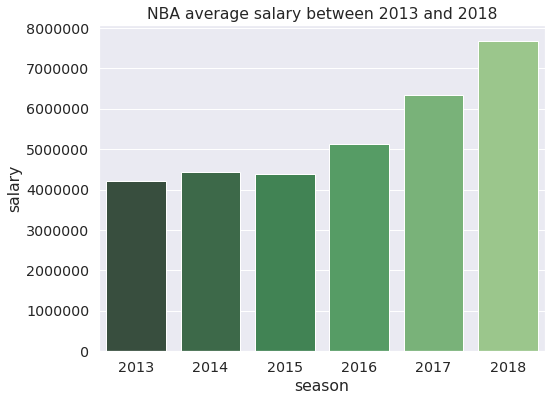

In [36]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid', font_scale=1.3)
ax = sns.barplot(x='season', y='salary', data=avgSalary, palette=sns.color_palette("YlGn_d"))
ax.set_title("NBA average salary between 2013 and 2018")
plt.savefig("./images/average-salary.png", dpi=300, bbox_inches='tight')
plt.show();

As we can see, the average NBA salary has been steadily increasing over the years. To account for this, we'll normalize each player's annual salary by dividing it by NBA's salary cap for the year.

I pulled the data for the salary cap from [this link](https://en.wikipedia.org/wiki/NBA_salary_cap).

In [37]:
salaryCap = pd.DataFrame(data={'season': [2013, 2014, 2015, 2016, 2017, 2018],
                               'cap': [58044000, 58679000, 63065000, 70000000, 94143000, 99093000]
                              })

In [38]:
NBAdata_norm = NBAdata.merge(salaryCap, how="inner", on="season")
NBAdata_norm['salary'] = NBAdata_norm['salary'] / NBAdata_norm['cap']
NBAdata_norm = NBAdata_norm.drop(columns=['cap'])

In [39]:
NBAdata_norm.head()

,firstName,lastName,season,minutes,points,assists,turnovers,steals,blocks,fouls,...,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,bench,starter,salary
0,A.J.,Price,2015,8.800000,1.200000,1.200000,0.200000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.600000,1.000000,0.000000,0.000854
1,Aaron,Brooks,2015,22.987805,11.634146,3.182927,1.914634,0.658537,0.182927,2.304878,...,0.355152,2.121951,1.768293,0.564605,0.390244,1.634146,2.024390,0.743902,0.256098,0.014513
2,Aaron,Gordon,2015,16.957447,5.170213,0.702128,0.808511,0.446809,0.468085,1.765957,...,0.145389,1.297872,0.936170,0.392198,0.978723,2.617021,3.595745,0.829787,0.170213,0.063300
3,Adreian,Payne,2015,24.862069,7.172414,1.034483,1.517241,0.620690,0.310345,2.896552,...,0.017241,1.517241,1.000000,0.307472,1.620690,3.827586,5.448276,0.241379,0.758621,0.029419
4,Al,Horford,2015,30.500000,15.210526,3.210526,1.315789,0.894737,1.276316,1.618421,...,0.138158,1.855263,1.407895,0.453476,1.723684,5.473684,7.197368,0.000000,1.000000,0.190280


In order to choose the features we want, we need to first visualize the impact each feature has on the `salary` column. I computed the correlation matrix and plotted a correlation heat map to visualize the correlation between each feature.

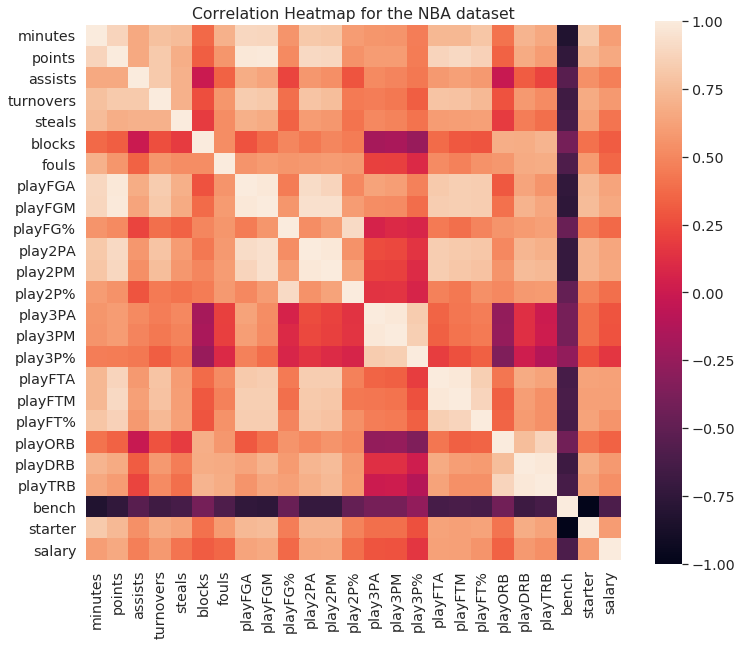

In [40]:
correlation_matrix = NBAdata_norm.iloc[:, 3:].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, square=True)
plt.title("Correlation Heatmap for the NBA dataset")
plt.savefig("./images/correlation-heatmap.png", dpi=300, bbox_inches='tight')
plt.show();

To further visualize the linear relationship between features and \c{salary}, I took the four features with the highest correlation and plotted it against \c{salary}.

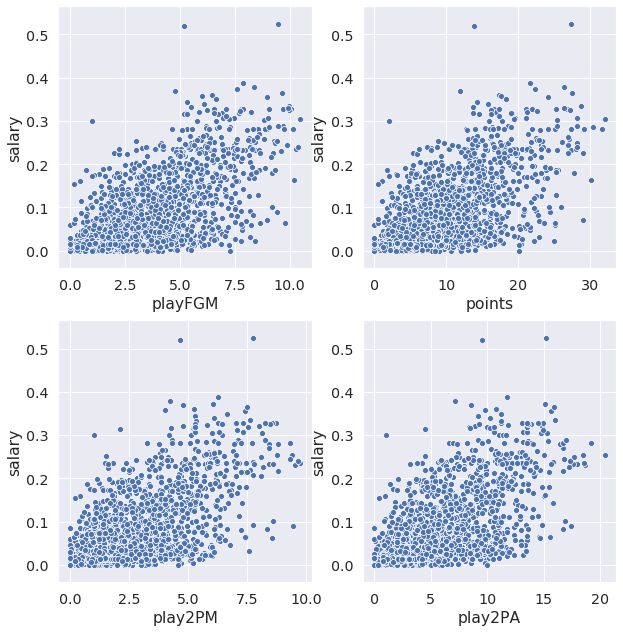

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(top=5, bottom=4)
sns.scatterplot(x='playFGM', y='salary', data=NBAdata_norm, ax=ax[0, 0])
sns.scatterplot(x='points', y='salary', data=NBAdata_norm, ax=ax[0, 1])
sns.scatterplot(x='play2PM', y='salary', data=NBAdata_norm, ax=ax[1, 0])
sns.scatterplot(x='play2PA', y='salary', data=NBAdata_norm, ax=ax[1, 1])
plt.savefig("./images/relationships.png", dpi=300, bbox_inches='tight')
plt.show();

## Data Splitting

In [42]:
train, test = train_test_split(NBAdata_norm, test_size=0.1, random_state=36)
train, val = train_test_split(train, test_size=0.2, random_state=36)

In [43]:
print("Number of sample points in train: %s" % (train.shape[0]))
print("Number of sample points in validation: %s" % (val.shape[0]))
print("Number of sample points in test: %s" % (test.shape[0]))

Number of sample points in train: 1589
Number of sample points in validation: 398
Number of sample points in test: 221


## Linear Model

### 10 Features

We'll first fit a linear model over the 10 highest features according to the correlation heatmap and use RMSE.

In [44]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [45]:
columns = ['playFGM', 'points', 'play2PM', 'play2PA', 'playFGA', 
           'playFTA', 'playFTM', 'minutes', 'starter', 'turnovers']
X_train, y_train = train[columns], train.iloc[:, -1]
X_val, y_val = val[columns], val.iloc[:, -1]
X_test, y_test = test[columns], test.iloc[:, -1]

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

print("Training error: %.4f" % (rmse(y_train, train_predictions)))
print("Validation error: %.4f" % (rmse(y_val, val_predictions)))
print("Test error: %.4f" % (rmse(y_test, model.predict(X_test))))

Training error: 0.0554
Validation error: 0.0602
Test error: 0.0583


### More features!

What if we use every feature?

In [48]:
X_train, y_train = train.iloc[:, 3:-1], train.iloc[:, -1]
X_val, y_val = val.iloc[:, 3:-1], val.iloc[:, -1]
X_test, y_test = test.iloc[:, 3:-1], test.iloc[:, -1]

In [49]:
X_train.shape

(1589, 24)

In [50]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [51]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

print("Training error: %.4f" % (rmse(y_train, train_predictions)))
print("Validation error: %.4f" % (rmse(y_val, val_predictions)))
print("Test error: %.4f" % (rmse(y_test, model.predict(X_test))))

Training error: 0.0532
Validation error: 0.0584
Test error: 0.0568


### With Cross Validation

We'll use cross validation to choose the optimal number of features to use. The code is largely reused from Lab 7.

In [52]:
features_sorted = correlation_matrix['salary'].sort_values(ascending=False).index.to_numpy()[1:]
NBAdata_sorted = NBAdata_norm.loc[:, features_sorted]
NBAdata_sorted['salary'] = NBAdata_norm['salary']
NBAdata_sorted.head(5)

,playFGM,points,play2PM,play2PA,playFGA,playFTA,playFTM,minutes,starter,turnovers,...,play2P%,playFG%,fouls,playORB,blocks,play3PA,play3PM,play3P%,bench,salary
0,0.600000,1.200000,0.600000,1.400000,2.800000,0.000000,0.000000,8.800000,0.000000,0.200000,...,0.400000,0.173320,1.000000,0.000000,0.000000,1.400000,0.000000,0.000000,1.000000,0.000854
1,4.195122,11.634146,2.719512,6.146341,9.963415,2.121951,1.768293,22.987805,0.256098,1.914634,...,0.441215,0.416544,2.304878,0.390244,0.182927,3.817073,1.475610,0.355152,0.743902,0.014513
2,1.978723,5.170213,1.702128,3.404255,4.425532,1.297872,0.936170,16.957447,0.170213,0.808511,...,0.496013,0.458081,1.765957,0.978723,0.468085,1.021277,0.276596,0.145389,0.829787,0.063300
3,3.068966,7.172414,3.034483,7.068966,7.344828,1.517241,1.000000,24.862069,0.758621,1.517241,...,0.422676,0.409338,2.896552,1.620690,0.310345,0.275862,0.034483,0.017241,0.241379,0.029419
4,6.828947,15.210526,6.684211,12.223684,12.697368,1.855263,1.407895,30.500000,1.000000,1.315789,...,0.566854,0.556875,1.618421,1.723684,1.276316,0.473684,0.144737,0.138158,0.000000,0.190280


In [53]:
train, test = train_test_split(NBAdata_sorted, test_size=0.1, random_state=36)

In [54]:
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [55]:
from sklearn.model_selection import KFold

def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        model.fit(split_X_train, split_Y_train)
        error = rmse(split_Y_valid, model.predict(split_X_valid))
        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [56]:
errors = []
models = []
for N in range(1, X_train.shape[1] + 1):
    model = LinearRegression(normalize=True)
    error = compute_CV_error(model, X_train.iloc[:, :N], y_train)
    models.append(model)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = np.min(errors)
best_model = models[np.argmin(errors)]

print("Best error: %.4f" % best_err)
print("Use the first %d features" % best_num_features)

Best error: 0.0548
Use the first 24 features


In [57]:
print("Training error: %.4f" % (rmse(y_train, best_model.predict(X_train.iloc[:, :24]))))
print("Test error: %.4f" % (rmse(y_test, best_model.predict(X_test.iloc[:, :24]))))

Training error: 0.0543
Test error: 0.0554


## Model Analysis

First, we'll plot the actual salary versus the predicted salary.

In [58]:
test_predictions = best_model.predict(X_test.iloc[:, :24])

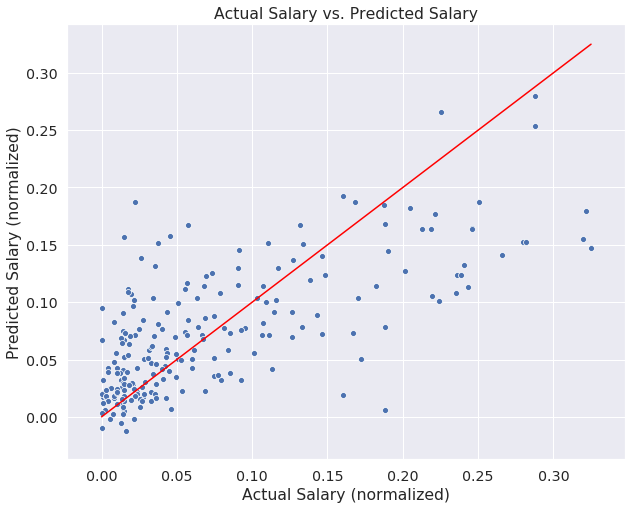

In [59]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(y_test, test_predictions)
sns.lineplot(y_test, y_test, color='Red', ax=ax)
ax.set(xlabel='Actual Salary (normalized)', ylabel='Predicted Salary (normalized)')
ax.set_title('Actual Salary vs. Predicted Salary')
plt.savefig("./images/linear-regression.png", dpi=300, bbox_inches='tight')
plt.show();

Next, we'll make a residual plot to see how well our model predicted the test set.

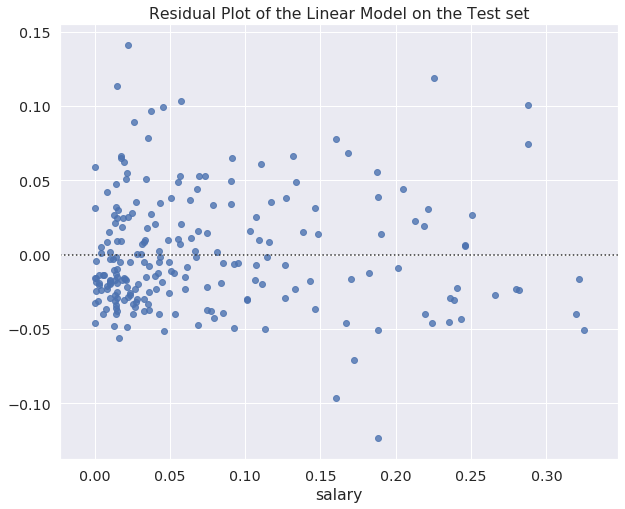

In [60]:
plt.figure(figsize=(10, 8))
ax = sns.residplot(y_test, test_predictions)
ax.set_title("Residual Plot of the Linear Model on the Test set")
plt.savefig("./images/residual.png", dpi=300, bbox_inches='tight')
plt.show();